# Bottle

In [2]:
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from models import VAE_tanh, VAE_sigmoid, VAE_ResNet, initialize_weights
from utils import visualize_pixel_distribution, show_8x4_images, plot_training_validation_loss, visualize_reconstruction, visualize_gradients, plot_and_calculate_losses
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dataset import SingleFolderDataset
from train_model import vae_loss, train_vae
from test_model import calculate_losses_for_category, calculate_metrics

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

In [4]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4070 SUPER , device num:0


In [5]:
image_size = 256

In [6]:
train_data_path = 'data/train/bottle'
val_data_path = 'data/val/bottle'
test_data_path = 'data/test/bottle'

In [7]:
batch_size = 32

input_dim=3
feature_dim=64
latent_dim=512

learning_rate=0.00005
epochs=500

### 資料正規化到 [-1, 1]，使用 Tanh 當作激活函數

In [7]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images to [-1, 1] range
])


train_dataset = SingleFolderDataset(folder_path=train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SingleFolderDataset(folder_path=val_data_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print("train: ", len(train_dataset))
print("val: ", len(val_dataset))

train:  167
val:  42


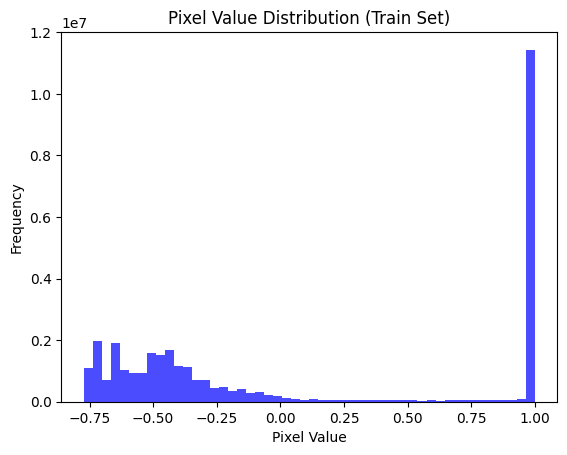

In [8]:
visualize_pixel_distribution(train_loader)

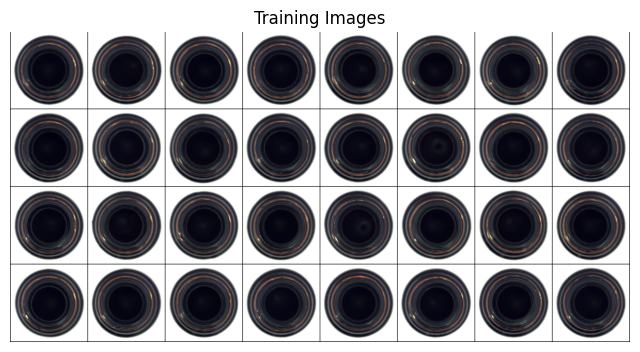

In [9]:
show_8x4_images(train_loader)

In [10]:
vae_tanh = VAE_tanh(input_dim, feature_dim, latent_dim).to(device)
initialize_weights(vae_tanh)

print(vae_tanh.encoder)
print(vae_tanh.decoder)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.1)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.1)
  (12): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): LeakyReLU(negati

In [11]:
optimizer = optim.Adam(vae_tanh.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

train_losses_tanh, val_losses_tanh = train_vae(vae_tanh, train_loader, val_loader, optimizer, scheduler, vae_loss, epochs=epochs, device=device)

Epoch [1/500]: Train Loss: 211382.3144, Val Loss: 108554.5446
Epoch [2/500]: Train Loss: 155235.0460, Val Loss: 109687.8988
Epoch [3/500]: Train Loss: 119764.1317, Val Loss: 98679.0015
Epoch [4/500]: Train Loss: 98076.9637, Val Loss: 88456.9643
Epoch [5/500]: Train Loss: 85070.8338, Val Loss: 79271.4524
Epoch [6/500]: Train Loss: 75812.9179, Val Loss: 73295.1354
Epoch [7/500]: Train Loss: 68205.9938, Val Loss: 69440.8869
Epoch [8/500]: Train Loss: 61490.0632, Val Loss: 65231.5759
Epoch [9/500]: Train Loss: 55699.7571, Val Loss: 54456.3690
Epoch [10/500]: Train Loss: 51097.9459, Val Loss: 50961.1324
Epoch [11/500]: Train Loss: 46841.8058, Val Loss: 48139.9777
Epoch [12/500]: Train Loss: 42664.3320, Val Loss: 42813.8199
Epoch [13/500]: Train Loss: 38776.6518, Val Loss: 38466.4807
Epoch [14/500]: Train Loss: 35693.5438, Val Loss: 35388.1577
Epoch [15/500]: Train Loss: 32662.2158, Val Loss: 32651.1525
Epoch [16/500]: Train Loss: 29839.6319, Val Loss: 32955.5997
Epoch [17/500]: Train Loss: 

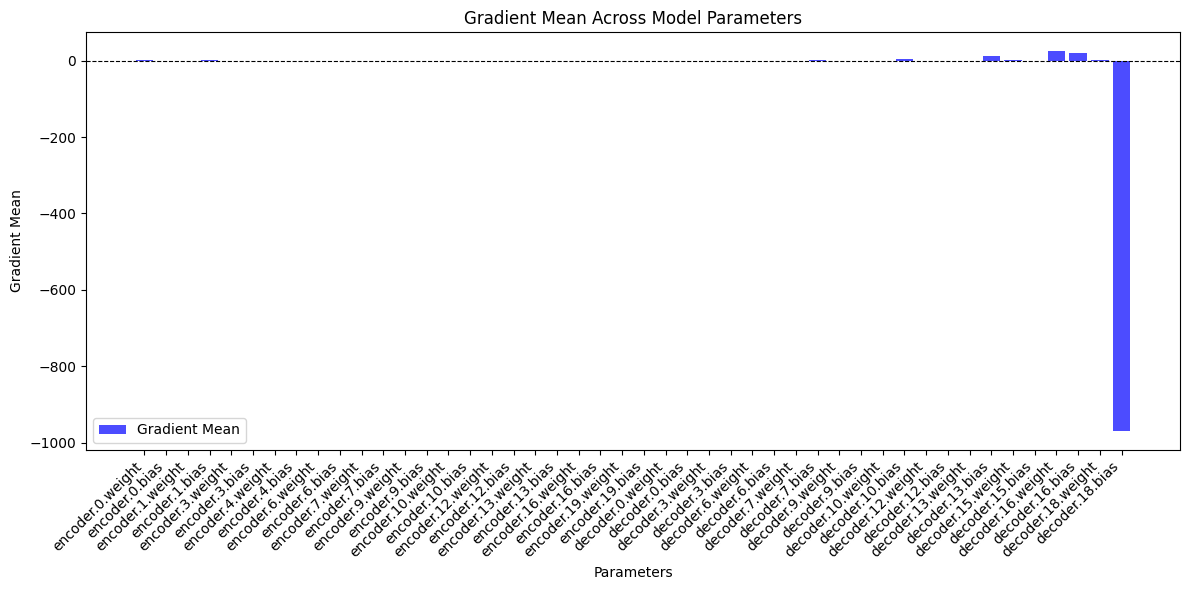

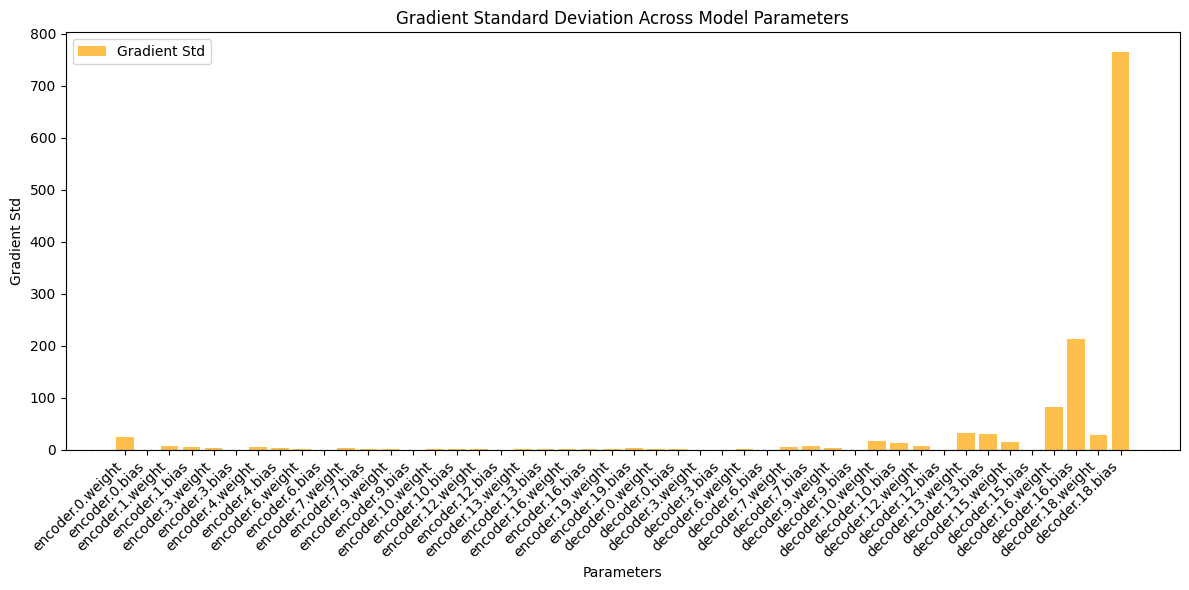

In [12]:
visualize_gradients(vae_tanh)

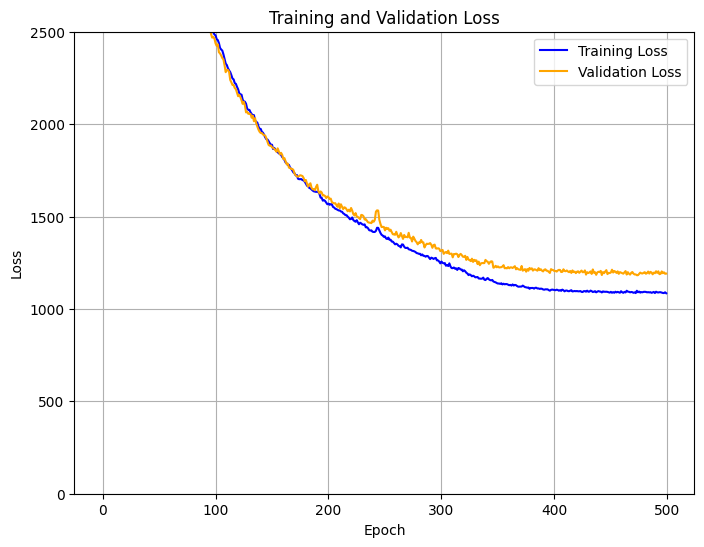

In [30]:
plot_training_validation_loss(train_losses_tanh, val_losses_tanh, (0, 2500))

In [ ]:
# torch.save(vae_tanh.state_dict(), "params/bottle_tanh.pth")

### 資料正規化到 [0, 1]，使用 sigmoid 當作激活函數

In [15]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])

train_dataset = SingleFolderDataset(folder_path=train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SingleFolderDataset(folder_path=val_data_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

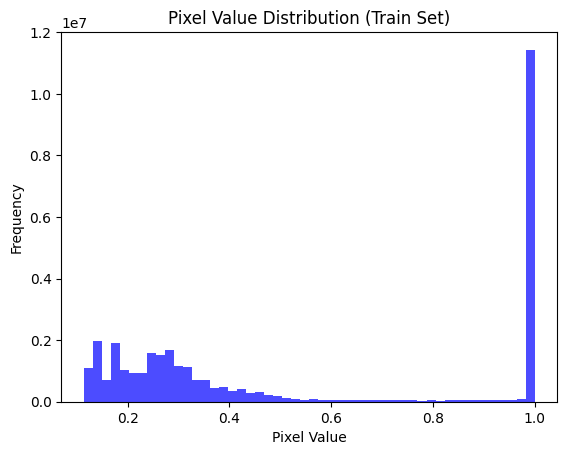

In [16]:
visualize_pixel_distribution(train_loader)

In [17]:
vae_sigmoid = VAE_sigmoid(input_dim, feature_dim, latent_dim).to(device)
initialize_weights(vae_sigmoid)

In [18]:
optimizer = optim.Adam(vae_sigmoid.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

torch.cuda.empty_cache()
train_losses_sigmoid, val_losses_sigmoid = train_vae(vae_sigmoid, train_loader, val_loader, optimizer, scheduler, vae_loss, epochs=epochs, device=device)

Epoch [1/500]: Train Loss: 58481.4214, Val Loss: 26575.2426
Epoch [2/500]: Train Loss: 34974.1257, Val Loss: 25639.5097
Epoch [3/500]: Train Loss: 28223.8668, Val Loss: 23852.3315
Epoch [4/500]: Train Loss: 24109.4653, Val Loss: 21952.8553
Epoch [5/500]: Train Loss: 20801.5800, Val Loss: 21664.2467
Epoch [6/500]: Train Loss: 18256.4161, Val Loss: 22095.1157
Epoch [7/500]: Train Loss: 16248.5051, Val Loss: 21746.0614
Epoch [8/500]: Train Loss: 14610.1855, Val Loss: 20733.9940
Epoch [9/500]: Train Loss: 13193.7517, Val Loss: 19060.1987
Epoch [10/500]: Train Loss: 12007.8210, Val Loss: 17314.6923
Epoch [11/500]: Train Loss: 11012.2510, Val Loss: 15403.2645
Epoch [12/500]: Train Loss: 10128.7820, Val Loss: 13817.5458
Epoch [13/500]: Train Loss: 9343.7164, Val Loss: 12374.5143
Epoch [14/500]: Train Loss: 8689.7646, Val Loss: 11715.2703
Epoch [15/500]: Train Loss: 8082.2009, Val Loss: 10006.1940
Epoch [16/500]: Train Loss: 7564.3525, Val Loss: 8863.4448
Epoch [17/500]: Train Loss: 7057.0057,

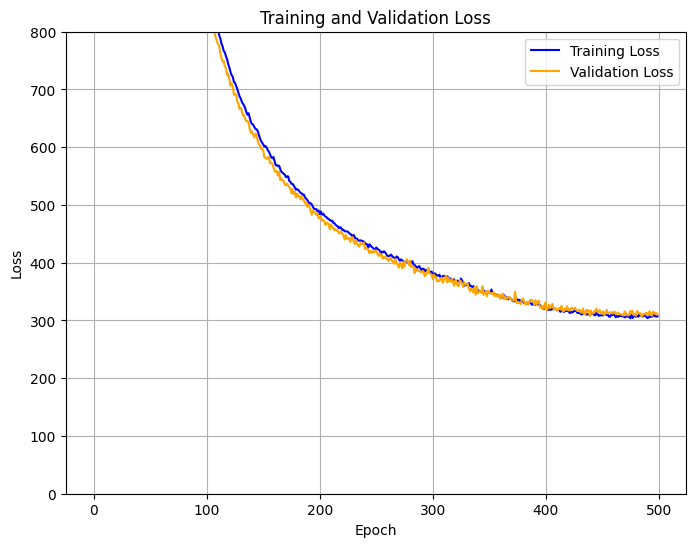

In [29]:
plot_training_validation_loss(train_losses_sigmoid, val_losses_sigmoid, (0, 800))

In [ ]:
# torch.save(vae_sigmoid.state_dict(), "params/bottle_sigmoid.pth")

### 嘗試 Resnet 結構

In [21]:
vae_resnet = VAE_ResNet(input_dim, feature_dim, latent_dim).to(device)
initialize_weights(vae_resnet)

In [22]:
optimizer = optim.Adam(vae_resnet.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

torch.cuda.empty_cache()
train_losses_resnet, val_losses_resnet = train_vae(vae_resnet, train_loader, val_loader, optimizer, scheduler, vae_loss, epochs=epochs, device=device)

Epoch [1/500]: Train Loss: 46257.6514, Val Loss: 26229.8609
Epoch [2/500]: Train Loss: 37526.8576, Val Loss: 26479.1354
Epoch [3/500]: Train Loss: 30796.7249, Val Loss: 25532.1161
Epoch [4/500]: Train Loss: 26106.7535, Val Loss: 23153.2262
Epoch [5/500]: Train Loss: 22250.5808, Val Loss: 20352.8869
Epoch [6/500]: Train Loss: 19161.7440, Val Loss: 17503.0093
Epoch [7/500]: Train Loss: 16566.8232, Val Loss: 15207.7173
Epoch [8/500]: Train Loss: 14409.8118, Val Loss: 14177.9699
Epoch [9/500]: Train Loss: 12629.9307, Val Loss: 11710.0326
Epoch [10/500]: Train Loss: 11081.6615, Val Loss: 10317.8218
Epoch [11/500]: Train Loss: 9795.0142, Val Loss: 9854.0634
Epoch [12/500]: Train Loss: 8725.0153, Val Loss: 8516.0562
Epoch [13/500]: Train Loss: 7823.3259, Val Loss: 7675.0422
Epoch [14/500]: Train Loss: 7116.8092, Val Loss: 7336.3785
Epoch [15/500]: Train Loss: 6530.5399, Val Loss: 6383.6091
Epoch [16/500]: Train Loss: 5991.7526, Val Loss: 5914.9855
Epoch [17/500]: Train Loss: 5566.2779, Val Lo

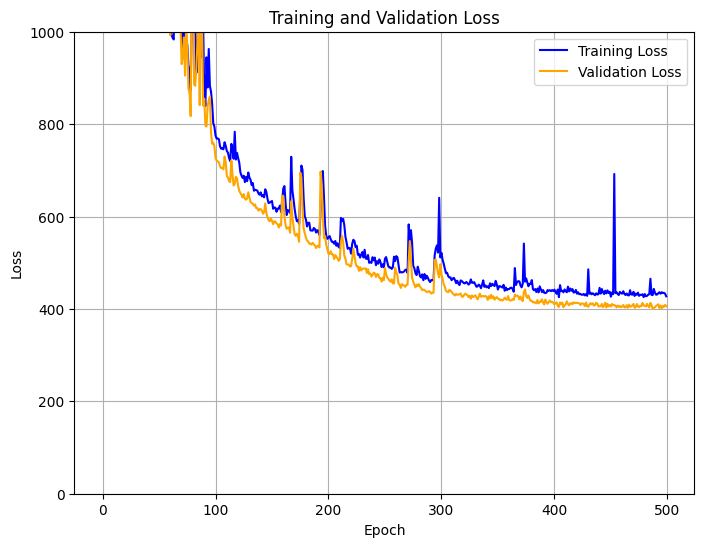

In [27]:
plot_training_validation_loss(train_losses_resnet, val_losses_resnet, (0, 1000))

In [ ]:
# torch.save(vae_resnet.state_dict(), "params/bottle_resnet.pth")

## Test

In [8]:
model = VAE_sigmoid(input_dim, feature_dim, latent_dim).to(device)
model.load_state_dict(torch.load("params/bottle_sigmoid.pth"))

C:\Users\wei\AppData\Local\Temp\ipykernel_40492\3851623294.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("params/bottle_sigmoid.pth"))

<All keys matched successfully>

In [9]:
# 定義圖像處理的 transform
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])

# 定義反正規化的 transform
inverse_transform = transforms.Compose([
    transforms.ToPILImage()  # 轉回 PIL 圖像
])

Error:
loss: 898.3825073242188


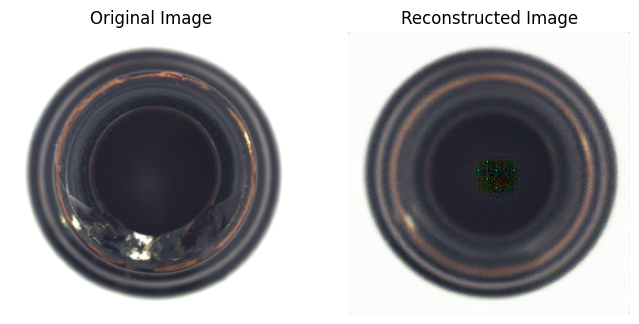

Good:
loss: 423.2543640136719


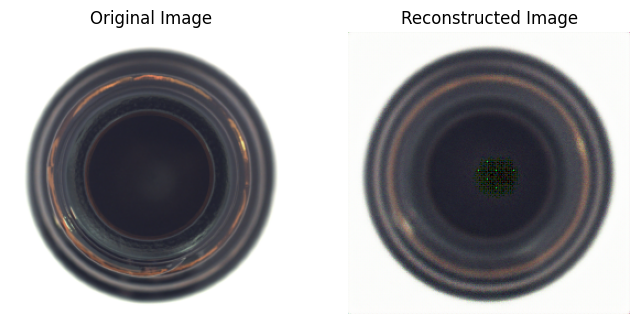

In [10]:
print("Error:")
image_path = "data/test/bottle/error/0.png"
visualize_reconstruction(model, vae_loss, image_path, transform, inverse_transform, device)


print("Good:")
image_path = "data/test/bottle/good/000.png"
visualize_reconstruction(model, vae_loss, image_path, transform, inverse_transform, device)

good avg:  368.7570434570313
defective avg:  658.1810021778894


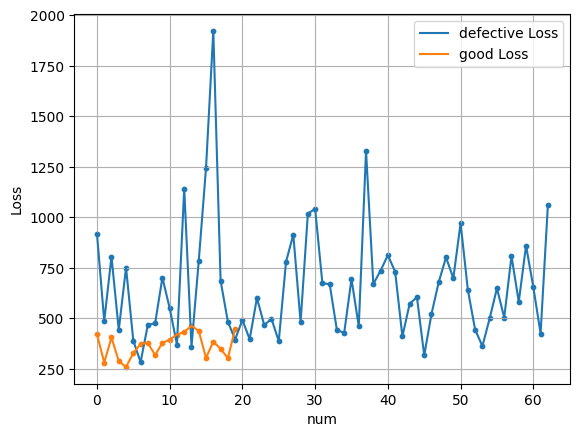

In [11]:
good_losses, error_losses = calculate_losses_for_category(test_data_path, model, vae_loss, transform, device=device)

plot_and_calculate_losses(good_losses, error_losses)

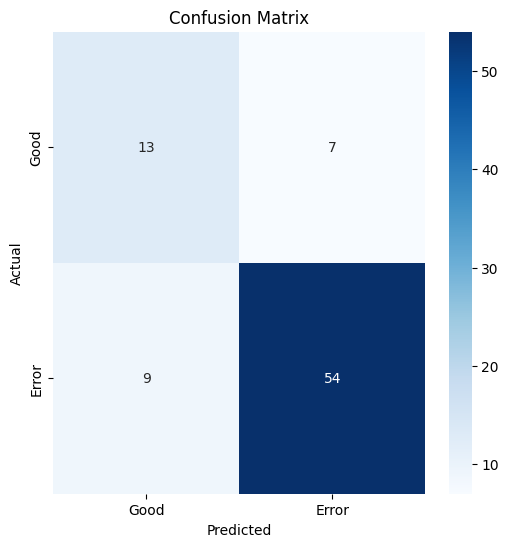

accuracy: 0.8072289156626506, F1 score: 0.8709677419354839


In [12]:
threshold = 400

accuracy, f1_score = calculate_metrics(test_data_path, model, vae_loss, transform, threshold, device=device)
print(f'accuracy: {accuracy}, F1 score: {f1_score}')